<a href="https://colab.research.google.com/github/upashanadutta23/DLPROJECT/blob/main/sp25_HarUpaYam_data02_prep_ipy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A. Introduction & Dataset Overview

In this project our goal is to develop a deep learning model using a neural network to classify brain MRI scans as either Cognitively Normal (CN) or Alzheimer’s Disease (AD). The model will leverage brain imaging data from the OASIS-1 dataset, along with demographic and clinical metadata, to assist in the early detection and diagnosis of Alzheimer’s Disease.

**Objective:** Classify individuals as either Cognitively Normal (CN) or Alzheimer’s Disease (AD) using MRI scans and clinical metadata.

**Input (X):**

Tabular Data (metadata.csv) → Age, sex, MMSE score, image quality, etc.

Image Data (OASIS-1.zip) → Structural brain MRI scans.

**Output (y):**

Binary Classification:

0 → Cognitively Normal (CN)

1 → Alzheimer's Disease (AD)

In [ ]:
# install Hugging Face Datasets
!pip install datasets

# optional installs: NiBabel and PyTorch
!pip install nibabel
!pip install torch torchvision
!pip install imbalanced-learn==0.11.0
!pip install scikit-learn==1.3.0
!pip install imbalanced-learn
!pip install zipfile


ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [ ]:
import nibabel as nib
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset, load_from_disk
from imblearn.over_sampling import SMOTE
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import zipfile
import os



In [ ]:
import numpy as np

In [ ]:
def preprocess_nifti(example):
    """
    Loads a .nii.gz file, crops, normalizes, and resamples to 96^3.
    Returns a numpy array (or tensor) in example["img"].
    """
    nii_path = example["nii_filepath"]

    # Load volume data with error handling
    try:
        vol = nib.load(nii_path).get_fdata()
    except Exception as e:
        raise ValueError(f"Error loading NIfTI file {nii_path}: {e}")

    # Crop sub-volume
    vol = vol[7:105, 8:132, :108]  # shape: (98, 124, 108)

    # Shift intensities to be non-negative
    vol = vol + abs(vol.min())
    # Normalize to [0,1]
    vol = vol / vol.max()

    # Convert to torch.Tensor: (1,1,D,H,W)
    t_tensor = torch.from_numpy(vol).float().unsqueeze(0).unsqueeze(0)

    # Scale factor based on (124 -> 96) for the y-dimension
    scale_factor = 96 / 124
    downsampled = F.interpolate(
        t_tensor,
        scale_factor=(scale_factor, scale_factor, scale_factor),
        mode="trilinear",
        align_corners=False
    )

    # Now pad each dimension to exactly 96 (symmetric padding)
    _, _, d, h, w = downsampled.shape
    pad_d = 96 - d
    pad_h = 96 - h
    pad_w = 96 - w
    padding = (
        pad_w // 2, pad_w - pad_w // 2,
        pad_h // 2, pad_h - pad_h // 2,
        pad_d // 2, pad_d - pad_d // 2
    )
    final_img = F.pad(downsampled, padding)  # shape => (1, 1, 96, 96, 96)
    final_img = final_img.squeeze(0)

    # Store as numpy or keep as torch.Tensor
    example["img"] = final_img.numpy()  # If you want numpy array
    # example["img"] = final_img  # If you prefer to keep it as tensor

    return example

In [ ]:

drive.mount("/content/drive", force_remount=True)

import pandas as pd
metadata_path = "/content/drive/MyDrive/metadata.csv"
metadata = pd.read_csv(metadata_path)
metadata.head()


Mounted at /content/drive


,t1_local_path,split,study,participant_id,session_id,age,sex,clinical_diagnosis,scanner_manufacturer,scanner_model,field_strength,image_quality_rating,total_intracranial_volume,radiata_id
0,DLBS/sub-0028326/ses-01/anat/msub-0028326_ses-...,train,DLBS,0028326,01,66,male,cognitively_normal,Philips,Achieva,3T,2.114547,1518.74,1
1,DLBS/sub-0028327/ses-01/anat/msub-0028327_ses-...,train,DLBS,0028327,01,73,female,cognitively_normal,Philips,Achieva,3T,2.534683,1325.90,2
2,DLBS/sub-0028328/ses-01/anat/msub-0028328_ses-...,train,DLBS,0028328,01,30,male,cognitively_normal,Philips,Achieva,3T,2.295338,1638.25,3
3,DLBS/sub-0028331/ses-01/anat/msub-0028331_ses-...,train,DLBS,0028331,01,77,female,cognitively_normal,Philips,Achieva,3T,1.955475,1329.82,6
4,DLBS/sub-0028332/ses-01/anat/msub-0028332_ses-...,train,DLBS,0028332,01,71,male,cognitively_normal,Philips,Achieva,3T,2.668323,1545.15,7


In [ ]:
# Assuming the column containing the study identifier is called 'study'
oasis1_metadata = metadata[metadata['study'] == 'OASIS-1']

# Display the filtered metadata
oasis1_metadata.head()

,t1_local_path,split,study,participant_id,session_id,age,sex,clinical_diagnosis,scanner_manufacturer,scanner_model,field_strength,image_quality_rating,total_intracranial_volume,radiata_id
2430,OASIS-1/sub-OASIS10001/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10001,M000,74,female,cognitively_normal,Siemens,Vision,1.5T,1.838200,1263.92,3196
2431,OASIS-1/sub-OASIS10002/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10002,M000,55,female,cognitively_normal,Siemens,Vision,1.5T,1.866688,1150.82,3197
2432,OASIS-1/sub-OASIS10003/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10003,M000,73,female,Alzheimers_disease,Siemens,Vision,1.5T,1.852032,1386.11,3198
2433,OASIS-1/sub-OASIS10005/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10005,M000,18,male,cognitively_normal,Siemens,Vision,1.5T,1.852903,1666.84,3200
2434,OASIS-1/sub-OASIS10009/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10009,M000,20,female,cognitively_normal,Siemens,Vision,1.5T,1.846645,1509.45,3203


In [ ]:
print('unique values in study column from metadata:',metadata['study'].unique())

#filterring with oasis-1
oasis1_metadata = metadata[metadata['study'] == 'OASIS-1']
oasis1_metadata.head()

#display unique_values
print('unique values in the clinical_diagonosis:',oasis1_metadata['clinical_diagnosis'].unique())

#filter metadata for alzhemeirs disease within oasis1
alzheimers_metadata = oasis1_metadata[oasis1_metadata['clinical_diagnosis'] == 'Alzheimer']
alzheimers_metadata.head()

#display no.of cases that are cognitively normal and alzheimers disease cases in oasis1
print(oasis1_metadata['clinical_diagnosis'].value_counts())

unique values in study column from metadata: ['DLBS' 'IXI' 'NKI-RS' 'OASIS-1' 'OASIS-2']
unique values in the clinical_diagonosis: ['cognitively_normal' 'Alzheimers_disease']
clinical_diagnosis
cognitively_normal    314
Alzheimers_disease    100
Name: count, dtype: int64


In [ ]:
oasis1_metadata.head()

,t1_local_path,split,study,participant_id,session_id,age,sex,clinical_diagnosis,scanner_manufacturer,scanner_model,field_strength,image_quality_rating,total_intracranial_volume,radiata_id
2430,OASIS-1/sub-OASIS10001/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10001,M000,74,female,cognitively_normal,Siemens,Vision,1.5T,1.838200,1263.92,3196
2431,OASIS-1/sub-OASIS10002/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10002,M000,55,female,cognitively_normal,Siemens,Vision,1.5T,1.866688,1150.82,3197
2432,OASIS-1/sub-OASIS10003/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10003,M000,73,female,Alzheimers_disease,Siemens,Vision,1.5T,1.852032,1386.11,3198
2433,OASIS-1/sub-OASIS10005/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10005,M000,18,male,cognitively_normal,Siemens,Vision,1.5T,1.852903,1666.84,3200
2434,OASIS-1/sub-OASIS10009/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10009,M000,20,female,cognitively_normal,Siemens,Vision,1.5T,1.846645,1509.45,3203


Metadata-Based ML Approach

In [ ]:
print(oasis1_metadata.isnull().sum())  # Identify missing values

t1_local_path                0
split                        0
study                        0
participant_id               0
session_id                   0
age                          0
sex                          0
clinical_diagnosis           0
scanner_manufacturer         0
scanner_model                0
field_strength               0
image_quality_rating         0
total_intracranial_volume    0
radiata_id                   0
dtype: int64


In [ ]:
print(oasis1_metadata['clinical_diagnosis'].unique())

['cognitively_normal' 'Alzheimers_disease']


In [ ]:
# Update the mapping based on the correct values in the column
oasis1_metadata['clinical_diagnosis'] = oasis1_metadata['clinical_diagnosis'].map({'cognitively_normal': 0, 'Alzheimers_disease': 1}).fillna(-1)

# Verify the updated encoding
print(oasis1_metadata['clinical_diagnosis'].unique())

[0 1]


<ipython-input-115-051c7c1111dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oasis1_metadata['clinical_diagnosis'] = oasis1_metadata['clinical_diagnosis'].map({'cognitively_normal': 0, 'Alzheimers_disease': 1}).fillna(-1)


In [ ]:
print(oasis1_metadata['clinical_diagnosis'])

2430    0
2431    0
2432    1
2433    0
2434    0
       ..
3750    1
3751    0
3752    1
3753    1
3754    0
Name: clinical_diagnosis, Length: 414, dtype: int64


In [ ]:
oasis1_metadata['Sex'] = oasis1_metadata['sex'].str.lower().map({'male': 0, 'female': 1}).fillna(-1)
print(oasis1_metadata['Sex'])

2430    1
2431    1
2432    1
2433    0
2434    1
       ..
3750    1
3751    0
3752    1
3753    1
3754    1
Name: Sex, Length: 414, dtype: int64


<ipython-input-117-c544f4a026c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oasis1_metadata['Sex'] = oasis1_metadata['sex'].str.lower().map({'male': 0, 'female': 1}).fillna(-1)


In [ ]:
print(oasis1_metadata.columns)

Index(['t1_local_path', 'split', 'study', 'participant_id', 'session_id',
       'age', 'sex', 'clinical_diagnosis', 'scanner_manufacturer',
       'scanner_model', 'field_strength', 'image_quality_rating',
       'total_intracranial_volume', 'radiata_id', 'Sex'],
      dtype='object')


In [ ]:
numerical_features = ['age', 'total_intracranial_volume', 'image_quality_rating']
scaler = StandardScaler()
oasis1_metadata[numerical_features] = scaler.fit_transform(oasis1_metadata[numerical_features])


<ipython-input-119-13649a8e0131>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oasis1_metadata[numerical_features] = scaler.fit_transform(oasis1_metadata[numerical_features])


In [ ]:
print(oasis1_metadata['clinical_diagnosis'].value_counts())

clinical_diagnosis
0    314
1    100
Name: count, dtype: int64


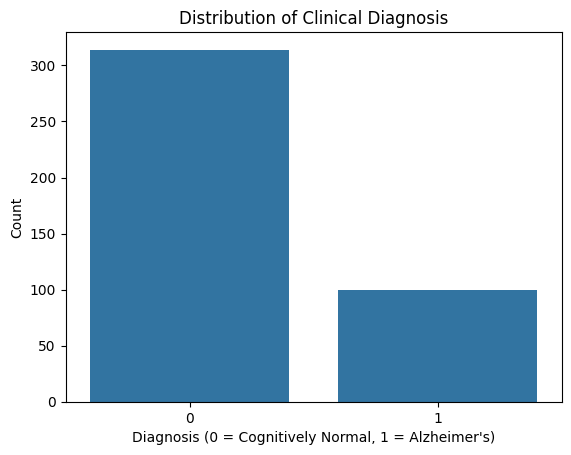

In [ ]:

sns.countplot(x=oasis1_metadata['clinical_diagnosis'])
plt.title('Distribution of Clinical Diagnosis')
plt.xlabel('Diagnosis (0 = Cognitively Normal, 1 = Alzheimer\'s)')
plt.ylabel('Count')
plt.show()

We can clearly see that the dataset is imbalanced.
 By applying SMOTE, we can generate new synthetic samples of the Alzheimer's Disease class, making the dataset more balanced and improving the performance of your model on this class.

In [ ]:
# Assuming 'X' is your feature data and 'y' is your target variable
X = oasis1_metadata[['age', 'total_intracranial_volume', 'image_quality_rating','Sex']]
y = oasis1_metadata['clinical_diagnosis']

# Apply SMOTE
smote = SMOTE(random_state=42)  # You can specify a random state for reproducibility
X_resampled, y_resampled = smote.fit_resample(X, y)



# Check new distribution
print("Original class distribution:", y.value_counts())
print("Resampled class distribution:", pd.Series(y_resampled).value_counts())


Original class distribution: clinical_diagnosis
0    314
1    100
Name: count, dtype: int64
Resampled class distribution: clinical_diagnosis
0    314
1    314
Name: count, dtype: int64


Original class distribution:
 clinical_diagnosis
0    314
1    100
Name: count, dtype: int64
Resampled class distribution:
 clinical_diagnosis
0    314
1    314
Name: count, dtype: int64


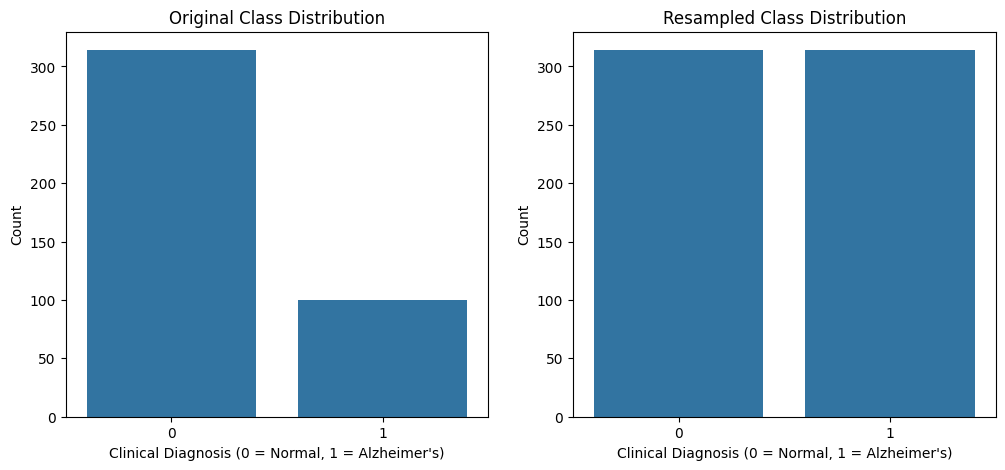

In [ ]:
print("Original class distribution:\n", y.value_counts())
print("Resampled class distribution:\n", pd.Series(y_resampled).value_counts())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original dataset
sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Original Class Distribution")
axes[0].set_xlabel("Clinical Diagnosis (0 = Normal, 1 = Alzheimer's)")
axes[0].set_ylabel("Count")

# Resampled dataset
sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title("Resampled Class Distribution")
axes[1].set_xlabel("Clinical Diagnosis (0 = Normal, 1 = Alzheimer's)")
axes[1].set_ylabel("Count")

plt.show()


From the above plot we can see that the metadata has been balanced using smote technique.

In [ ]:
import os

#Define the root directory for MRI files
mri_root_dir= "https://drive.google.com/drive/folders/1mfMeoaA40ytNe4UcJdLQUdzWrdcJXh40?usp=drive_link"

# Make a copy of oasis1_dataset
oasis1_metadata=oasis1_metadata.copy()

# Creat full MRI paths
oasis1_metadata. loc[:,'full_mri_path']= oasis1_metadata['t1_local_path'].apply (lambda x: os.path.join(mri_root_dir, x))

# Check if MRI files exist
oasis1_metadata.loc[:, "mri_exists"] = oasis1_metadata["full_mri_path"].apply(lambda x: os.path.exists(x))


# Print summary
print(oasis1_metadata["mri_exists"].value_counts())
print("MRI paths that are missing:", (~oasis1_metadata["mri_exists"]).sum())

# Display oasis1_metadata
oasis1_metadata.head()

mri_exists
False    414
Name: count, dtype: int64
MRI paths that are missing: 414


,t1_local_path,split,study,participant_id,session_id,age,sex,clinical_diagnosis,scanner_manufacturer,scanner_model,field_strength,image_quality_rating,total_intracranial_volume,radiata_id,Sex,full_mri_path,mri_exists
2430,OASIS-1/sub-OASIS10001/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10001,M000,0.845322,female,0,Siemens,Vision,1.5T,-0.295357,-1.304776,3196,1,https://drive.google.com/drive/folders/1mfMeoa...,False
2431,OASIS-1/sub-OASIS10002/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10002,M000,0.085489,female,0,Siemens,Vision,1.5T,0.018709,-2.124930,3197,1,https://drive.google.com/drive/folders/1mfMeoa...,False
2432,OASIS-1/sub-OASIS10003/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10003,M000,0.805331,female,1,Siemens,Vision,1.5T,-0.142866,-0.418706,3198,1,https://drive.google.com/drive/folders/1mfMeoa...,False
2433,OASIS-1/sub-OASIS10005/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10005,M000,-1.394188,male,0,Siemens,Vision,1.5T,-0.133264,1.617029,3200,0,https://drive.google.com/drive/folders/1mfMeoa...,False
2434,OASIS-1/sub-OASIS10009/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10009,M000,-1.314205,female,0,Siemens,Vision,1.5T,-0.202255,0.475704,3203,1,https://drive.google.com/drive/folders/1mfMeoa...,False


LOAD AND PREPROCESS MRI IMAGES

MRI FILE PATHS

In [ ]:

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/OASIS-1.zip"  # Path to the zip file
extract_path = "/content/data/OASIS-1/"  # Choose an appropriate extraction path

# Extract if not already extracted
if not os.path.exists(extract_path):
  os.makedirs(extract_path)  # Create the extraction directory if it doesn't exist
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)
  print("Extraction complete. Image files are now accessible.")
  mri_files_dir = extract_path  # The directory containing the extracted MRI files



In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

#Define the root directory for MRI files
mri_root_dir= "/content/data/OASIS-1/OASIS-1"

# Make a copy of oasis1_dataset
oasis1_metadata=oasis1_metadata.copy()

# Creat full MRI paths
oasis1_metadata. loc[:,'full_mri_path']= oasis1_metadata['t1_local_path'].apply (lambda x: os.path.join(mri_root_dir, x))

# Check if MRI files exist
oasis1_metadata.loc[:, "mri_exists"] = oasis1_metadata["full_mri_path"].apply(lambda x: os.path.exists(x))


# Print summary
print(oasis1_metadata["mri_exists"].value_counts())
print("MRI paths that are missing:", (~oasis1_metadata["mri_exists"]).sum())

# Display oasis1_metadata
oasis1_metadata.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mri_exists
False    414
Name: count, dtype: int64
MRI paths that are missing: 414


,t1_local_path,split,study,participant_id,session_id,age,sex,clinical_diagnosis,scanner_manufacturer,scanner_model,field_strength,image_quality_rating,total_intracranial_volume,radiata_id,Sex,full_mri_path,mri_exists,mri_image
0,OASIS-1/sub-OASIS10001/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10001,M000,0.845322,female,0,Siemens,Vision,1.5T,-0.295357,-1.304776,3196,1,/content/data/OASIS-1/OASIS-1/OASIS-1/sub-OASI...,False,None
1,OASIS-1/sub-OASIS10002/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10002,M000,0.085489,female,0,Siemens,Vision,1.5T,0.018709,-2.124930,3197,1,/content/data/OASIS-1/OASIS-1/OASIS-1/sub-OASI...,False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,OASIS-1/sub-OASIS10003/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10003,M000,0.805331,female,1,Siemens,Vision,1.5T,-0.142866,-0.418706,3198,1,/content/data/OASIS-1/OASIS-1/OASIS-1/sub-OASI...,False,None
3,OASIS-1/sub-OASIS10005/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10005,M000,-1.394188,male,0,Siemens,Vision,1.5T,-0.133264,1.617029,3200,0,/content/data/OASIS-1/OASIS-1/OASIS-1/sub-OASI...,False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,OASIS-1/sub-OASIS10009/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10009,M000,-1.314205,female,0,Siemens,Vision,1.5T,-0.202255,0.475704,3203,1,/content/data/OASIS-1/OASIS-1/OASIS-1/sub-OASI...,False,None


In [ ]:
#MRI FILES DIRECTORY-OASIS1
mri_files_dir = r"C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\sub-OASIS10111\ses-M000\anat\msub-OASIS10111_ses-M000_T1w_brain_affine_mni.nii\msub-OASIS10111_ses-M000_T1w_brain_affine_mni.nii"
print(mri_files_dir)



C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\sub-OASIS10111\ses-M000\anat\msub-OASIS10111_ses-M000_T1w_brain_affine_mni.nii\msub-OASIS10111_ses-M000_T1w_brain_affine_mni.nii


In [ ]:
#making a copy of oasis1_dataset
oasis1_metadata=oasis1_metadata.copy()

In [ ]:
#create full mri paths
oasis1_metadata.loc[:,'full_mri_path'] = oasis1_metadata['t1_local_path'].apply(lambda x: os.path.join(mri_files_dir, x))
print(oasis1_metadata.loc[:,'full_mri_path'] )

0      C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
1      C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
2      C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
3      C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
4      C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
                             ...                        
409    C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
410    C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
411    C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
412    C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
413    C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...
Name: full_mri_path, Length: 414, dtype: object


In [ ]:
#checking the mri_files
oasis1_metadata.loc[:,"mri_exists"]=oasis1_metadata['full_mri_path'].apply(lambda x: os.path.exists(x))
print(oasis1_metadata.loc[:,"mri_exists"])

0      False
1      False
2      False
3      False
4      False
       ...  
409    False
410    False
411    False
412    False
413    False
Name: mri_exists, Length: 414, dtype: bool


In [ ]:
print(oasis1_metadata.loc[:,"mri_exists"].value_counts())
print("Missing mri paths:",(~oasis1_metadata['mri_exists']).sum())

oasis1_metadata.head()


mri_exists
False    414
Name: count, dtype: int64
Missing mri paths: 414


,t1_local_path,split,study,participant_id,session_id,age,sex,clinical_diagnosis,scanner_manufacturer,scanner_model,field_strength,image_quality_rating,total_intracranial_volume,radiata_id,Sex,full_mri_path,mri_exists,mri_image
0,OASIS-1/sub-OASIS10001/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10001,M000,0.845322,female,0,Siemens,Vision,1.5T,-0.295357,-1.304776,3196,1,C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...,False,None
1,OASIS-1/sub-OASIS10002/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10002,M000,0.085489,female,0,Siemens,Vision,1.5T,0.018709,-2.124930,3197,1,C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...,False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,OASIS-1/sub-OASIS10003/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10003,M000,0.805331,female,1,Siemens,Vision,1.5T,-0.142866,-0.418706,3198,1,C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...,False,None
3,OASIS-1/sub-OASIS10005/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10005,M000,-1.394188,male,0,Siemens,Vision,1.5T,-0.133264,1.617029,3200,0,C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...,False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,OASIS-1/sub-OASIS10009/ses-M000/anat/msub-OASI...,train,OASIS-1,OASIS10009,M000,-1.314205,female,0,Siemens,Vision,1.5T,-0.202255,0.475704,3203,1,C:\Users\harsh\Downloads\OASIS-1 (2)\OASIS-1\s...,False,None


In [ ]:
#image preprocessing

def load_mri_image(image_path):
       try:
           img = nib.load(image_path)
           data = img.get_fdata()

           # Normalization
           data_min = data.min()
           data_max = data.max()

           if data_min < data_max:
               data = (data - data_min) / (data_max - data_min)
           else:
               data = data - data_min
           return data

       except Exception as e:
           print(f"Error loading image {image_path}: {e}")
           return None

In [ ]:
oasis1_metadata.loc[:, "mri_image"] = oasis1_metadata["full_mri_path"].apply(load_mri_image)
oasis1_metadata.head()


In [ ]:
oasis1_metadata = oasis1_metadata.reset_index(drop=True)

In [ ]:
# Select an image (e.g., the first image)
image_data = oasis1_metadata.loc[0, "mri_image"]

# Check if image data is loaded successfully
if image_data is not None:
    # Display the image using matplotlib
    plt.imshow(image_data[:, :, image_data.shape[2] // 2], cmap="gray")  # Display a middle slice
    plt.show()
else:
    print("Error: Image data is None. Check the image loading process.")

In [ ]:
# Select an image (e.g., the first image)
image_data = oasis1_metadata.loc[0, "mri_image"]

# Display the image using matplotlib
plt.imshow(image_data[:, :, image_data.shape[2] // 2], cmap="gray")  # Display a middle slice
plt.show()

In [ ]:
# List all files in the extracted directory
print("Checking extracted files...")
files = os.listdir(extract_path)
print(f"Total files/folders found: {len(files)}")
print("Sample files/folders:", files[:10])  # Print first 10 files/folders

# Now check for .nii files specifically
mri_files = [f for f in files if f.endswith('.nii') or f.endswith('.nii.gz')]
print(f"Total MRI files found: {len(mri_files)}")


In [ ]:
#Processing the scanned Brain Data
def preprocess_nifti(example):
  nii_path = example["nii_filepath"]
  #Load the volume data
  vol = nib.load(nii_path).get_fdata()
  #cropping the sub volume
  vol = vol[7:105, 8:132, :108] #(98,124,108)
  #shifting intensities so that it is not negative
  vol = vol + abs(vol.min())
  #normalising it to [0,1]
  vol = vol / vol.max()
  #converting it to torch tensor(1,1,D,H,W)
  t_tensor = torch.from_numpy(vol).unsqueeze(0).unsqueeze(0)
  #scale factor based on y dimension(124 -> 96)
  scale_factor = 96/124
  #downsampling the tensor
  downsampled = F.interpolate(t_tensor,scale_factor = (scale_factor,scale_factor,scale_factor),mode = "trilinear",align_corners = False)
  #scale factor based on y dimension(124 -> 96)
  scale_factor = 96/124
  #downsampling the tensor
  downsampled = F.interpolate(t_tensor,scale_factor = (scale_factor,scale_factor,scale_factor),mode = "trilinear",align_corners = False)
  #symmetric padding(dim = 96)
  _, _, d,h, w = downsampled.shape
  pad_d = (96 - d) // 2
  pad_h = (96 - h) // 2
  pad_w = (96 - w) // 2
  padding = (pad_w//2 , pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2, pad_d//2, pad_d - pad_d//2)
  final_image = F.pad(downsampled,padding) ##current shape = (1,1,96,96,96)
  final_image = final_image.squeeze(0)
  #Storing the image as numpy
  example["img"] = final_image.numpy()
  return example


In [ ]:
##LOADING THE DATASET FROM HUGGING FACE
ds_train = load_dataset("radiata-ai/brain-structure", split = "train", trust_remote_code= True)
ds_test = load_dataset("radiata-ai/brain-structure", split = "test", trust_remote_code= True)
ds_val = load_dataset("radiata-ai/brain-structure", split = "validation", trust_remote_code= True)


In [ ]:
##THE PREPROCESSING WILL NOW BE APPLIED FOR EACH SPLIT SET
ds_train = ds_train.map(preprocess_nifti)
ds_test = ds_test.map(preprocess_nifti)
ds_val = ds_val.map(preprocess_nifti)
#returning it in pytorch tensor format
ds_train.set_format(type = 'torch', columns = ['img'])
ds_test.set_format(type = 'torch', columns = ['img'])
ds_val.set_format(type = 'torch', columns = ['img'])


In [ ]:
##Save data to disk for uploading
ds_train.save_to_disk("exported_brain_images/train")
ds_test.save_to_disk("exported_brain_images/test")
ds_val.save_to_disk("exported_brain_images/val")


In [ ]:
#Load the data from disk
ds_train = load_from_disk("exported_brain_images/train")
ds_test = load_from_disk("exported_brain_images/test")
ds_val = load_from_disk("exported_brain_images/val")

In [ ]:
#MRI FILE PATHS

# Mount Google Drive
#drive.mount('/content/drive')

#MRI FILES DIRECTORY-OASIS1
#mri_files_dir = "/content/data/OASIS-1/"

#mri_files_dir = "/content/data/OASIS-1/OASIS-1"

#making a copy of oasis1_dataset
#oasis1_metadata=oasis1_metadata.copy()

#create full mri paths
#oasis1_metadata.loc[:,'full_mri_path'] = oasis1_metadata['t1_local_path'].apply(lambda x: os.path.join(mri_files_dir, x))

#checking the mri_files
#oasis1_metadata.loc[:,"mri_exists"]=oasis1_metadata['full_mri_path'].apply(lambda x: os.path.exists(x))

#print